# Welcome to an example Binder

This notebook uses `seaborn`, which we have because we included it in our `requirements.txt` file

## Setup our plotting

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

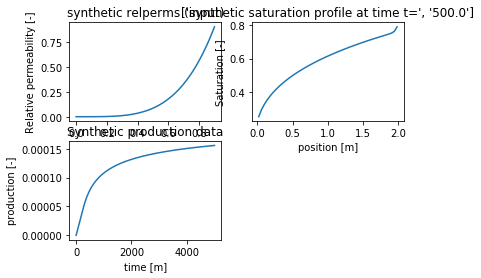

'\n##########################################################################\n# Data needed for computer practical: \n#\n# The (synthetic) data you will need for the computerlab \n# is the production data given by:\n#\n# t       : time\n# np_o    : production data at times t\n#\n# and (for comparison only) the saturation profile so(z)\n#\n# z       : vector with spatial z - positions\n# so_data : (synthetic) saturation profiles at time t=searchTime=500\n#\n# In addition you will need the parameters specifying your core  \n# i.e. permeability, core length, porosity\n# and necessary fluid parameters (density, viscosity) as specified in\n# the "user specified parameters" section\n#\n##########################################################################\n'

In [2]:

class Model:
    def __init__(self):
        # [User specified parameters]
        # initial physics
        self.rho_o = 800                                     # [kg/m3] desnity of oil
        self.rho_a = 1                                       # [kg/m3] density of air
        self.drho_oa = (self.rho_o - self.rho_a)
        self.g = 9.81                                        # [m2/s]  gravitional accelaration
        self.visco_o = 1.2e-3                                # [Pa*s]  oil viscosity
        # column + rock properties
        self.area = 3.14159265359*0.01**2                          # [m2] cross-section area of tube
        self.area = 3.14159265359 *0.01**2  
        self.L = 2                                         # [m] domain size
        self.phi = 0.4                                       # [-]  porosity
        self.kz = 1e-10                                      # [m2] Absolute permeability
        self.dt_max = 0.05

        # rock - fluid + fluid - fluid parameters

        self.lambdaa = 2          #[-] sorting factor
        self.sor = 0.0            #[-] residual oil saturation
        self.swc = 0.1            #[-] residual water saturation
        self.kroe = 0.9           #[-] oil end point relative permability
        self.sigma_oa = 0.03      #[N / m] oil air interfacial tension
        self.gamma = 0.5          #[-] fudge factor for pc curve
        # # computation (bubbling presure or) entry pressure (in [Pa])
        self.pd = self.gamma*self.sigma_oa*np.sqrt(self.phi/self.kz)*((0.5-self.sor)/(1-self.sor-self.swc))**(1/self.lambdaa)
        # numerical parameters
        self.nz = 50                         # [-]       number of gridblocks
        self.endtime = 5000                  # [s] endtime
        self.nrOfPlots = 50                  #  [-] number of times the saturation and velocity inside the column will be stored
        # initial + boundary conditions
        self.pc_ze = self.pd                 # [Pa]  boundary condition (so = 1-swc)
        self.uo_0 = 0                        # [m/s] injection bc for oil
        self.initial_sat = 1 - self.swc      # [-]   initial saturation
        # copy interesting stuff
        self.t = []
        self.np_o = []
        self.z = []
        self.zv = []
        self.t_A = []
        self.so_A = []
        self.uo_A = []


    def run(self, compute_pc):
        # computation bubbling pressure or entry pressure( in [Pa])
        if compute_pc == 0:
            pd = 0
        else:
            pd = self.pd

        # Numerical model
        # 1D simulation part including pc and gravity effect
        rho_o = self.rho_o
        rho_a = self.rho_a
        g = self.g
        visco_o = self.visco_o
        # rock properties
        phi = self.phi
        kz = self.kz
        # rock fluid + fluid fluid parameters
        lambdaa = self.lambdaa
        sor = self.sor
        swc=self.swc
        kroe= self.kroe
        sigma_oe = self.sigma_oa
        gamma = self.gamma
        # numerical parameter
        L =self.L
        area = self.area
        nz  = self.nz

        # numerical grid
        dz = self.L /self.nz
        z= np.linspace(dz/2, self.L - dz/2, nz)
        zv = np.linspace(0, L, nz+1)
        zr = np.arange(1,nz)                                          #  [-] index range used for update velocities
        zr2 = np.arange(0,nz)                                         #   [-] index range used for saturation update

        # timing
        dt = 0.05
        nt = int(self.endtime/dt)
        t = np.arange(0,nt+dt)*dt
        dtp = self.endtime / self.nrOfPlots
        plotTime = np.arange(dtp, self.endtime+dtp, dtp)               # [s] time at which solution will be plotted
        plotTel = 0
        t_A = []
        so_A = np.zeros([nz, 50])
        uo_A = np.zeros([nz+1, nt])



        #initial and boundary conditions
        so_init = np.zeros(nz)
        so_init.fill(self.initial_sat)
        so = so_init
        pc_ze = self.pd
        uo_zo = self.uo_0
        np_o = [0]
        fig = []
        #fig, (axes1, axes2, axes3) = plt.subplots(1,3,  figsize=(15.0,3.0))

    # 1D simulation part including pc and gravity effect
        for i in range(0,nt):  # make a correct syntax
            # set old saturation equal to present saturation
            so_old = so
            # oil mobility and capillary pressure within each cell
            kro = np.zeros(nz-1)
            mob = np.zeros(nz-1)
            pc = np.zeros(nz-1)
            kro = kroe *((so-sor)/(1-sor-swc))**(2/lambdaa+3)
            mob = kz*kro/visco_o
            pc = pd*((so-sor)/(1-sor-swc))**(-1/lambdaa)
            # interpolated
            so_ze = 1-swc
            pc_ze = pd*((so_ze-sor)/(1-sor-swc))**(-1/lambdaa)
            # DPZ(i) : gradient within driving force from cell (i-1) to cell (i)
            DPZ = np.zeros(nz+1)
            DPZ[0] = 1
            DPZ[zr] = - ( (rho_o - rho_a) * g + ( pc[zr] - pc[zr-1] ) / dz )
            DPZ[nz] = - ( (rho_o - rho_a) * g + ( pc_ze  - pc[nz-1]  ) / dz )
            #  uo(i)  : flux from cell (i-1) to cell (i)
            # upstream weighted mobiities (i.e. take the mobility at the interface
            # from the direction the fluid is coming )
            uo = np.zeros(nz+1)
            uo[0] = 0
            uo[zr] = - (mob[zr-1] * (DPZ[zr] <= 0) + mob[zr] * ( DPZ[zr] > 0 )) * DPZ[zr]
            uo[nz] = -  mob[nz-1] * DPZ[nz]
            # saturation update
            so[zr2] = so_old[zr2] - dt/dz * (uo[zr2+1] - uo[zr2])/phi
            # Cumulitavie oil production
            np_o.append(np_o[i] + area * uo[nz]*dt)

            # plotting
            if not fig:
                if ((i*dt)>= plotTime[plotTel]):
                    t_A.append(i * dt)
                    so_A[:, plotTel] = so
                    uo_A[:, plotTel] = uo
                    plotTel += 1
                    # axes1.plot(z, so)
                    # axes1.set_title('Saturation')
                    # axes1.set_xlabel('z [m]')
                    # axes2.plot(zv, uo)
                    # axes2.set_ylabel(' u_o [m/s]')
                    # axes2.set_title('velocity (data)')
                    # axes3.plot(t[0:(i+1)], np_o[0:(i+1)])
                    # axes3.set_ylabel('N_p [m3]')
                    # axes3.set_title('cum.  production')
                    # axes3.set_xlim(0, self.endtime)
                    # #plt.pause(0.1)
                    # axes1.clear()
                    # axes2.clear()
                    # axes3.clear()
                    #plt.clf()
        #plt.show()


        #  copy interesting stuff

        self.t = t                          # All simulation time
        self.np_o = np_o                    # Oil production and all those times
        self.z = z                          # co-ordinates of cell centers
        self.zv = zv                        # co-ordinates of cell faces
        self.t_A = t_A                      # times at which saturation is stored
        self.so_A = so_A                    # Saturation at times specified by t_A
        self.uo_A = uo_A                    # Velocities at the times specified by t_A


import numpy as np
#from grav_drain_model import *
m = Model()

# - computation of (synthetic) relative permeability - saturation relationship

so_syn = np.linspace(m.sor, 1 - m.swc, 100)     # saturation range
no = 2/m.lambdaa+3                              # Brooks corey coeff for oil relperm
soe = (so_syn - m.sor)/(1 - m.swc - m.sor)      # Effective oil saturation
kro_syn = m.kroe*soe**no                        # Oil relative permeability

# Compute two phase flow including pc
compute_pc = 1       # parameter that specifies twther the capillary forces should be compute
m.run(compute_pc)    # the actual numerical simulation of the flow inside the column

# post processing data and plotting

z = m.z          # [1,nz] spatial co-ordinates of grid-block
nz = m.nz        # number of grid-blocks
zv = m.z         # [1,nz+1] spatial co-ordinate of cell-faces
t = m.t          # [1,nt] point in time at which production is determined
nt = len(t)      #  number of times the production is determined
np_o = m.np_o    # [1,nt] [(synthetic) production
t_A = m.t_A      # [nA,1] vector with time at which the saturation is sampled
nA = len(t_A)    # number of times the saturation is sampled
so_A = m.so_A    # [nz,nA] matrix with all saturation values
uo_A = m.so_A    # [nz+1,nA]

# plot of synthetic relative permeability - saturation relationship
plt.figure(2)
plt.subplot(2,2,1)
plt.plot(so_syn,kro_syn)
plt.xlabel('Saturation [-]')
plt.ylabel('Relative permeability [-]')
plt.title('synthetic relperms (input)')
#  Determine the index to the time vector t_A
searchTime = 500
y = [(x - searchTime)**2 for x in t_A]
value = min(y)
index = y.index(min(y))
searchTime = t_A[index]
so_data = so_A[:,index]
plt.subplot(2,2,2)
plt.plot(z,so_data)
plt.xlabel('position [m]')
plt.ylabel('Saturation [-]')
plt.title(['synthetic saturation profile at time t=', str(searchTime)])
plt.subplot(2,2,3)
plt.plot(t,np_o)
plt.xlabel('time [m]')
plt.ylabel('production [-]')
plt.title('Synthetic production data')
plt.show()

'''
##########################################################################
# Data needed for computer practical: 
#
# The (synthetic) data you will need for the computerlab 
# is the production data given by:
#
# t       : time
# np_o    : production data at times t
#
# and (for comparison only) the saturation profile so(z)
#
# z       : vector with spatial z - positions
# so_data : (synthetic) saturation profiles at time t=searchTime=500
#
# In addition you will need the parameters specifying your core  
# i.e. permeability, core length, porosity
# and necessary fluid parameters (density, viscosity) as specified in
# the "user specified parameters" section
#
##########################################################################
'''

## start answering exercises here




